In [1]:
pip install opencv-contrib-python


     |████████████████████████████████| 56.4 MB 60 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
net = cv.dnn.readNetFromTensorflow('graph_opt.pb') # weights

In [19]:
inWidth = 368
inHeight = 368
thr = 0.2 

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [6]:
img = cv.imread('pose1.jpg')

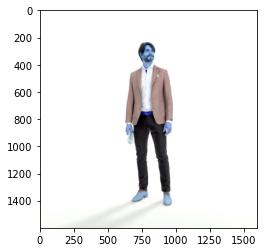

In [7]:
plt.imshow(img) # bgr: blue,green,red

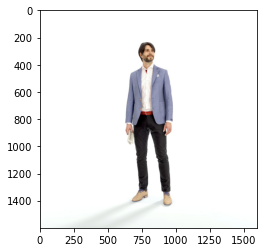

In [8]:
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

In [13]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    # configuring the net from In[2]
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight),(127.5,127.5,127.5),swapRB = True, crop = False))
    
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        # once you find the points, append them one by one
        points.append((int(x), int(y)) if conf > thr else None)
        
    # once the points are found, you need to pair them
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        # draw the lines and points, once paired
        # points are red and lines are green
        
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame

In [14]:
estimated_image = pose_estimation(img)

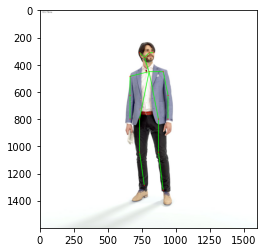

In [18]:
plt.imshow(cv.cvtColor(estimated_image,cv.COLOR_BGR2RGB))

# perform this demo on video

In [ ]:
cap = cv.VideoCapture('woman_running.mp4')
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError('Can not open video')

# opening the video takes time
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    # read frame by frame
    if not hasFrame: # if the video is corrupted inside
        cv.waitKey() 
        break
    # copy the previous function
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    # configuring the net from In[2]
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight),(127.5,127.5,127.5),swapRB = True, crop = False))
    
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        # once you find the points, append them one by one
        points.append((int(x), int(y)) if conf > thr else None)
        
    # once the points are found, you need to pair them
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        # draw the lines and points, once paired
        # points are red and lines are green
        
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    cv.imshow('Pose estimation tutorial',frame)
    

# perform on webcam

In [ ]:
cap = cv.VideoCapture(1)

cap.set(cv.CAP_PROP_FPS,10)
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError('Can not open webcam')

# opening the video takes time
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    # read frame by frame
    if not hasFrame: # if the video is corrupted inside
        cv.waitKey() 
        break
    # copy the previous function
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    # configuring the net from In[2]
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight),(127.5,127.5,127.5),swapRB = True, crop = False))
    
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        # once you find the points, append them one by one
        points.append((int(x), int(y)) if conf > thr else None)
        
    # once the points are found, you need to pair them
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        # draw the lines and points, once paired
        # points are red and lines are green
        
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    cv.imshow('Pose estimation tutorial',frame)